# Pass Rush Collision Model - Comprehensive Performance Visualizations

This notebook creates publication-ready visualizations for the capstone technical report, covering:

1. **Model Comparison**: Performance metrics across all models (baseline + tuned)
2. **ROC & PR Curves**: Visual discrimination analysis for classification performance
3. **Confusion Matrices**: Detailed error analysis for top 3 models
4. **Feature Importance**: Interpretation of key predictors (Random Forest, XGBoost, Logistic Regression)
5. **SHAP Analysis**: Advanced feature interpretation showing individual prediction contributions
6. **Prediction Distributions**: How models assign probabilities to pressure vs non-pressure events
7. **Calibration Curves**: How well predicted probabilities match actual outcomes
8. **Learning Curves**: Model performance vs training set size
9. **Business Impact**: Translating metrics to actionable insights for player health

In [2]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.0 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve, confusion_matrix,
    classification_report, ConfusionMatrixDisplay, RocCurveDisplay,
    PrecisionRecallDisplay
)
from sklearn.calibration import calibration_curve
import shap
import json
import warnings
warnings.filterwarnings('ignore')

# Set style for publication-quality figures
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

print("Libraries loaded successfully")

Libraries loaded successfully


## 1. Load Data and Prepare Features

In [4]:
# Load dataset
df = pd.read_csv('pass_rush_collision_data/pass_rush_collision_features_full.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nTarget distribution:")
print(df['generated_pressure'].value_counts())
print(f"\nClass balance:")
print(df['generated_pressure'].value_counts(normalize=True))

# Feature columns
feature_cols = [
    'min_distance', 'avg_distance', 'distance_at_start', 'distance_at_end',
    'frame_at_closest', 'rusher_max_speed', 'rusher_avg_speed',
    'rusher_speed_at_closest', 'qb_max_speed', 'qb_avg_speed',
    'qb_speed_at_closest', 'rusher_max_accel', 'rusher_avg_accel',
    'rusher_accel_at_closest', 'qb_max_accel', 'qb_avg_accel',
    'qb_accel_at_closest', 'combined_speed_at_closest', 'max_closing_speed',
    'avg_closing_speed', 'approach_angle', 'rusher_orientation_at_closest',
    'qb_orientation_at_closest', 'rusher_angle_alignment',
    'time_to_closest_approach', 'total_frames', 'play_duration',
    'collision_intensity_raw', 'weighted_closing_speed', 'collision_intensity'
]

X = df[feature_cols]
y = df['generated_pressure']

# Train-test split (same as modeling)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nFeatures: {len(feature_cols)}")

Dataset shape: (36362, 46)

Target distribution:
generated_pressure
0    32130
1     4232
Name: count, dtype: int64

Class balance:
generated_pressure
0    0.883615
1    0.116385
Name: proportion, dtype: float64

Training set: (29089, 30)
Test set: (7273, 30)

Features: 30


## 2. Load Best Hyperparameters and Train Models

In [5]:
# Load best hyperparameters from tuning
with open('pass_rush_collision_data/best_hyperparameters.json', 'r') as f:
    best_params = json.load(f)

print("Best hyperparameters loaded:")
for model_name, params in best_params.items():
    print(f"\n{model_name}:")
    print(params)

Best hyperparameters loaded:

logistic_regression:
{'C': 0.1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}

random_forest:
{'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}

svm:
{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}

knn:
{'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}

xgboost:
{'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.6}

random_forest_smote:
{'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [6]:
# Train top 3 models with best hyperparameters
print("Training top 3 models...\n")

# 1. SVM (Best overall)
print("Training SVM...")
svm_model = SVC(
    C=best_params['svm']['C'],
    gamma=best_params['svm']['gamma'],
    kernel=best_params['svm']['kernel'],
    class_weight='balanced',
    probability=True,
    random_state=42
)
svm_model.fit(X_train_scaled, y_train)
print("SVM trained successfully")

# 2. XGBoost (Best improvement)
print("\nTraining XGBoost...")
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
xgb_model = XGBClassifier(
    max_depth=best_params['xgboost']['max_depth'],
    learning_rate=best_params['xgboost']['learning_rate'],
    n_estimators=best_params['xgboost']['n_estimators'],
    subsample=best_params['xgboost']['subsample'],
    colsample_bytree=best_params['xgboost']['colsample_bytree'],
    min_child_weight=best_params['xgboost']['min_child_weight'],
    scale_pos_weight=scale_pos_weight,
    eval_metric='aucpr',
    random_state=42,
    tree_method='hist'
)
xgb_model.fit(X_train_scaled, y_train)
print("XGBoost trained successfully")

# 3. Logistic Regression (Most interpretable)
print("\nTraining Logistic Regression...")
lr_model = LogisticRegression(
    C=best_params['logistic_regression']['C'],
    penalty=best_params['logistic_regression']['penalty'],
    solver=best_params['logistic_regression']['solver'],
    max_iter=best_params['logistic_regression']['max_iter'],
    class_weight='balanced',
    random_state=42
)
lr_model.fit(X_train_scaled, y_train)
print("Logistic Regression trained successfully")

# 4. Random Forest (Ensemble baseline)
print("\nTraining Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=best_params['random_forest']['n_estimators'],
    max_depth=best_params['random_forest']['max_depth'],
    min_samples_split=best_params['random_forest']['min_samples_split'],
    min_samples_leaf=best_params['random_forest']['min_samples_leaf'],
    max_features=best_params['random_forest']['max_features'],
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train_scaled, y_train)
print("Random Forest trained successfully")

print("\n" + "="*50)
print("All models trained successfully!")
print("="*50)

Training top 3 models...

Training SVM...
SVM trained successfully

Training XGBoost...
XGBoost trained successfully

Training Logistic Regression...
Logistic Regression trained successfully

Training Random Forest...
Random Forest trained successfully

All models trained successfully!


## 3. Model Comparison: Performance Metrics Table

In [7]:
# Generate predictions for all models
models = {
    'SVM': svm_model,
    'XGBoost': xgb_model,
    'Logistic Regression': lr_model,
    'Random Forest': rf_model
}

results = []
predictions = {}
probabilities = {}

for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    predictions[name] = y_pred
    probabilities[name] = y_proba
    
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba),
        'PR-AUC': average_precision_score(y_test, y_proba)
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Balanced Accuracy', ascending=False)

print("\n" + "="*100)
print("MODEL PERFORMANCE COMPARISON (Test Set)")
print("="*100)
print(results_df.to_string(index=False))
print("\n" + "="*100)


MODEL PERFORMANCE COMPARISON (Test Set)
              Model  Accuracy  Balanced Accuracy  Precision   Recall  F1 Score  ROC-AUC   PR-AUC
                SVM  0.905679           0.914299   0.556899 0.925532  0.695382 0.966712 0.775035
Logistic Regression  0.904441           0.911546   0.553660 0.920804  0.691522 0.963975 0.792637
            XGBoost  0.910766           0.911018   0.573234 0.911348  0.703788 0.968831 0.811462
      Random Forest  0.927128           0.903340   0.636207 0.872340  0.735793 0.966802 0.792443




Performance comparison saved to: model_performance_comparison.png


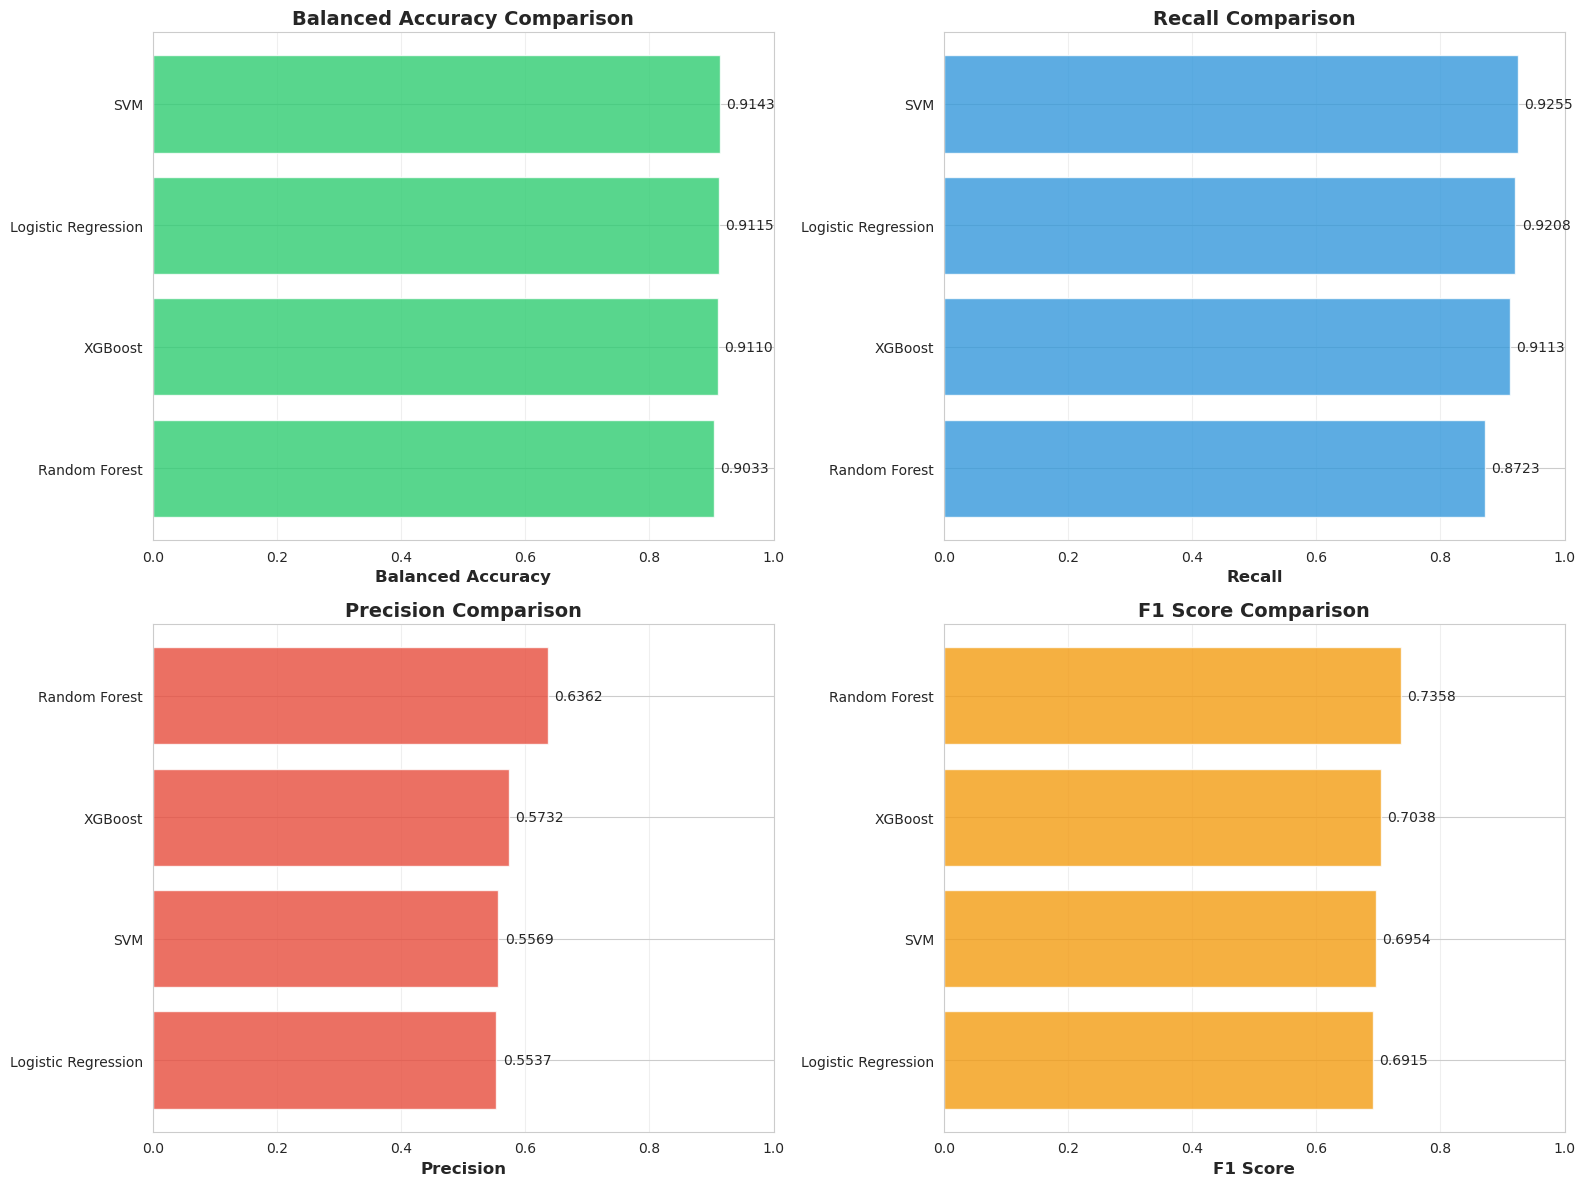

In [8]:
# Create performance comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Balanced Accuracy', 'Recall', 'Precision', 'F1 Score']
colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']

for idx, (metric, ax, color) in enumerate(zip(metrics, axes.flat, colors)):
    data = results_df.sort_values(metric, ascending=True)
    ax.barh(data['Model'], data[metric], color=color, alpha=0.8)
    ax.set_xlabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.set_xlim(0, 1.0)
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(data[metric]):
        ax.text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('pass_rush_collision_data/model_performance_comparison.png', dpi=300, bbox_inches='tight')
print("\nPerformance comparison saved to: model_performance_comparison.png")
plt.show()

## 4. ROC Curves: Model Discrimination Analysis

ROC curves saved to: roc_curves.png


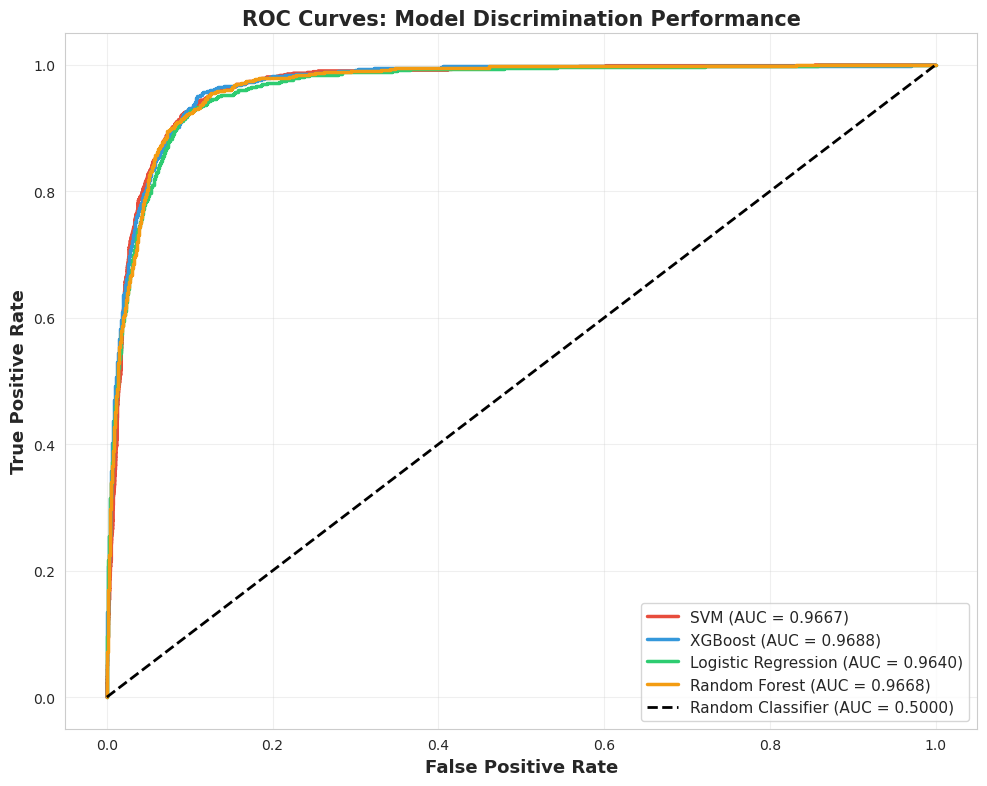

In [9]:
# Create ROC curve comparison
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']

for (name, model), color in zip(models.items(), colors):
    y_proba = probabilities[name]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    ax.plot(fpr, tpr, color=color, lw=2.5, 
            label=f'{name} (AUC = {roc_auc:.4f})')

# Diagonal reference line
ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.5000)')

ax.set_xlabel('False Positive Rate', fontsize=13, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=13, fontweight='bold')
ax.set_title('ROC Curves: Model Discrimination Performance', fontsize=15, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('pass_rush_collision_data/roc_curves.png', dpi=300, bbox_inches='tight')
print("ROC curves saved to: roc_curves.png")
plt.show()

## 5. Precision-Recall Curves: Performance on Imbalanced Data

Precision-Recall curves saved to: precision_recall_curves.png


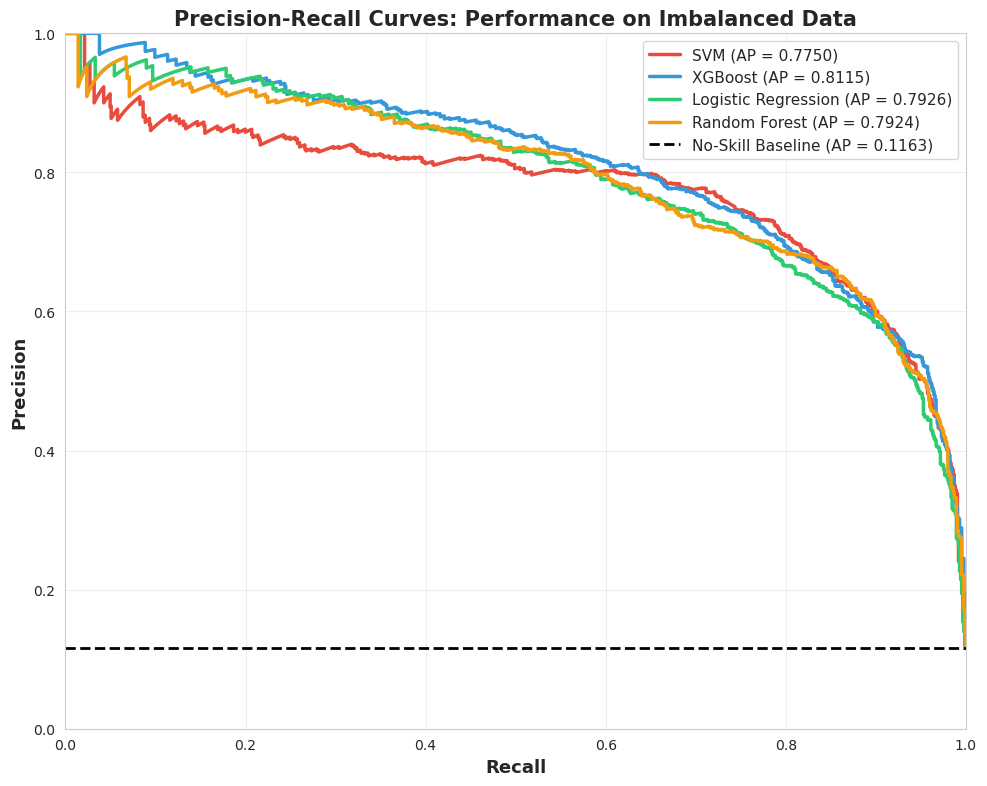

In [10]:
# Create Precision-Recall curve comparison
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']
baseline_precision = (y_test == 1).sum() / len(y_test)

for (name, model), color in zip(models.items(), colors):
    y_proba = probabilities[name]
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    
    ax.plot(recall, precision, color=color, lw=2.5,
            label=f'{name} (AP = {pr_auc:.4f})')

# Baseline (no-skill classifier)
ax.axhline(y=baseline_precision, color='k', linestyle='--', lw=2,
           label=f'No-Skill Baseline (AP = {baseline_precision:.4f})')

ax.set_xlabel('Recall', fontsize=13, fontweight='bold')
ax.set_ylabel('Precision', fontsize=13, fontweight='bold')
ax.set_title('Precision-Recall Curves: Performance on Imbalanced Data', fontsize=15, fontweight='bold')
ax.legend(loc='upper right', fontsize=11)
ax.grid(alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('pass_rush_collision_data/precision_recall_curves.png', dpi=300, bbox_inches='tight')
print("Precision-Recall curves saved to: precision_recall_curves.png")
plt.show()

## 6. Confusion Matrices: Error Analysis for Top 3 Models

Confusion matrices saved to: confusion_matrices.png


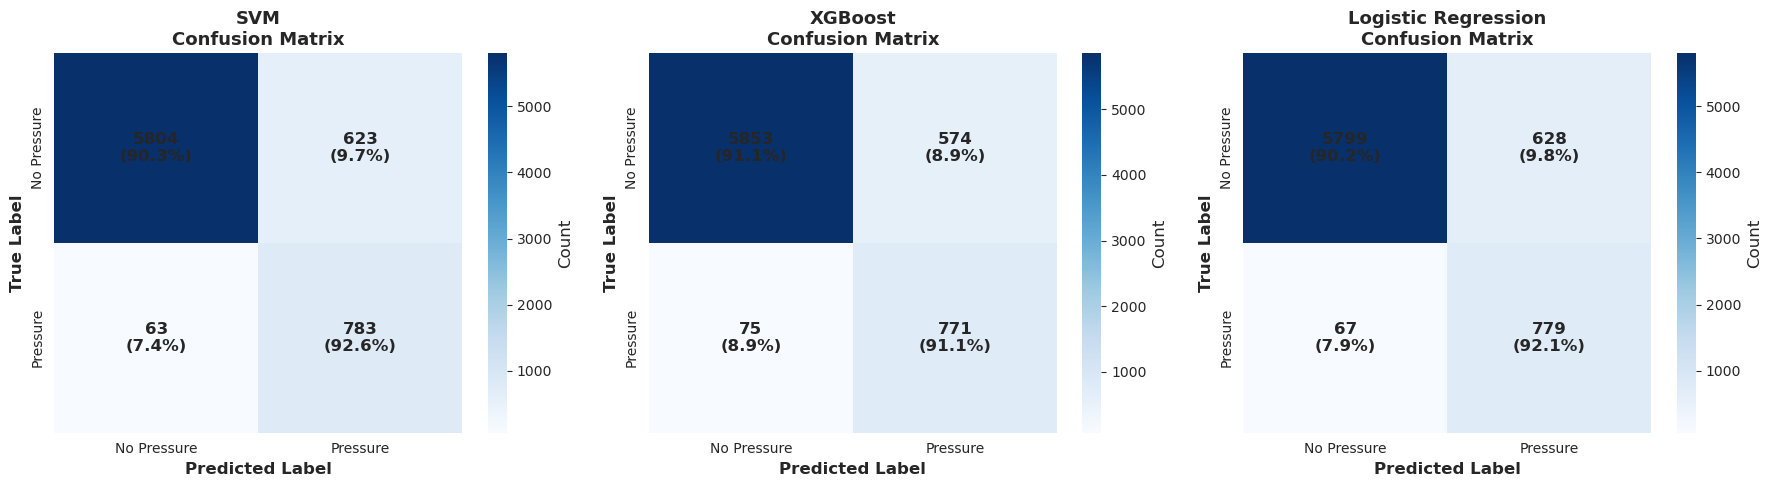

In [11]:
# Create confusion matrices for top 3 models
top_3_models = ['SVM', 'XGBoost', 'Logistic Regression']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, model_name in zip(axes, top_3_models):
    y_pred = predictions[model_name]
    cm = confusion_matrix(y_test, y_pred)
    
    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', ax=ax,
                cbar_kws={'label': 'Count'})
    
    # Add custom annotations with counts and percentages
    for i in range(2):
        for j in range(2):
            text = f'{cm[i, j]}\n({cm_percent[i, j]:.1f}%)'
            ax.text(j + 0.5, i + 0.5, text,
                   ha='center', va='center', fontsize=12, fontweight='bold')
    
    ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
    ax.set_title(f'{model_name}\nConfusion Matrix', fontsize=13, fontweight='bold')
    ax.set_xticklabels(['No Pressure', 'Pressure'])
    ax.set_yticklabels(['No Pressure', 'Pressure'])

plt.tight_layout()
plt.savefig('pass_rush_collision_data/confusion_matrices.png', dpi=300, bbox_inches='tight')
print("Confusion matrices saved to: confusion_matrices.png")
plt.show()

In [12]:
# Print detailed classification reports
print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORTS")
print("="*80)

for model_name in top_3_models:
    print(f"\n{model_name}:")
    print("-" * 80)
    y_pred = predictions[model_name]
    print(classification_report(y_test, y_pred, 
                                target_names=['No Pressure', 'Pressure'],
                                digits=4))


DETAILED CLASSIFICATION REPORTS

SVM:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

 No Pressure     0.9893    0.9031    0.9442      6427
    Pressure     0.5569    0.9255    0.6954       846

    accuracy                         0.9057      7273
   macro avg     0.7731    0.9143    0.8198      7273
weighted avg     0.9390    0.9057    0.9153      7273


XGBoost:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

 No Pressure     0.9873    0.9107    0.9475      6427
    Pressure     0.5732    0.9113    0.7038       846

    accuracy                         0.9108      7273
   macro avg     0.7803    0.9110    0.8256      7273
weighted avg     0.9392    0.9108    0.9191      7273


Logistic Regression:
--------------------------------------------------------------------------------
              precision    recal

## 7. Feature Importance Analysis

Feature importance analysis saved to: feature_importance_analysis.png


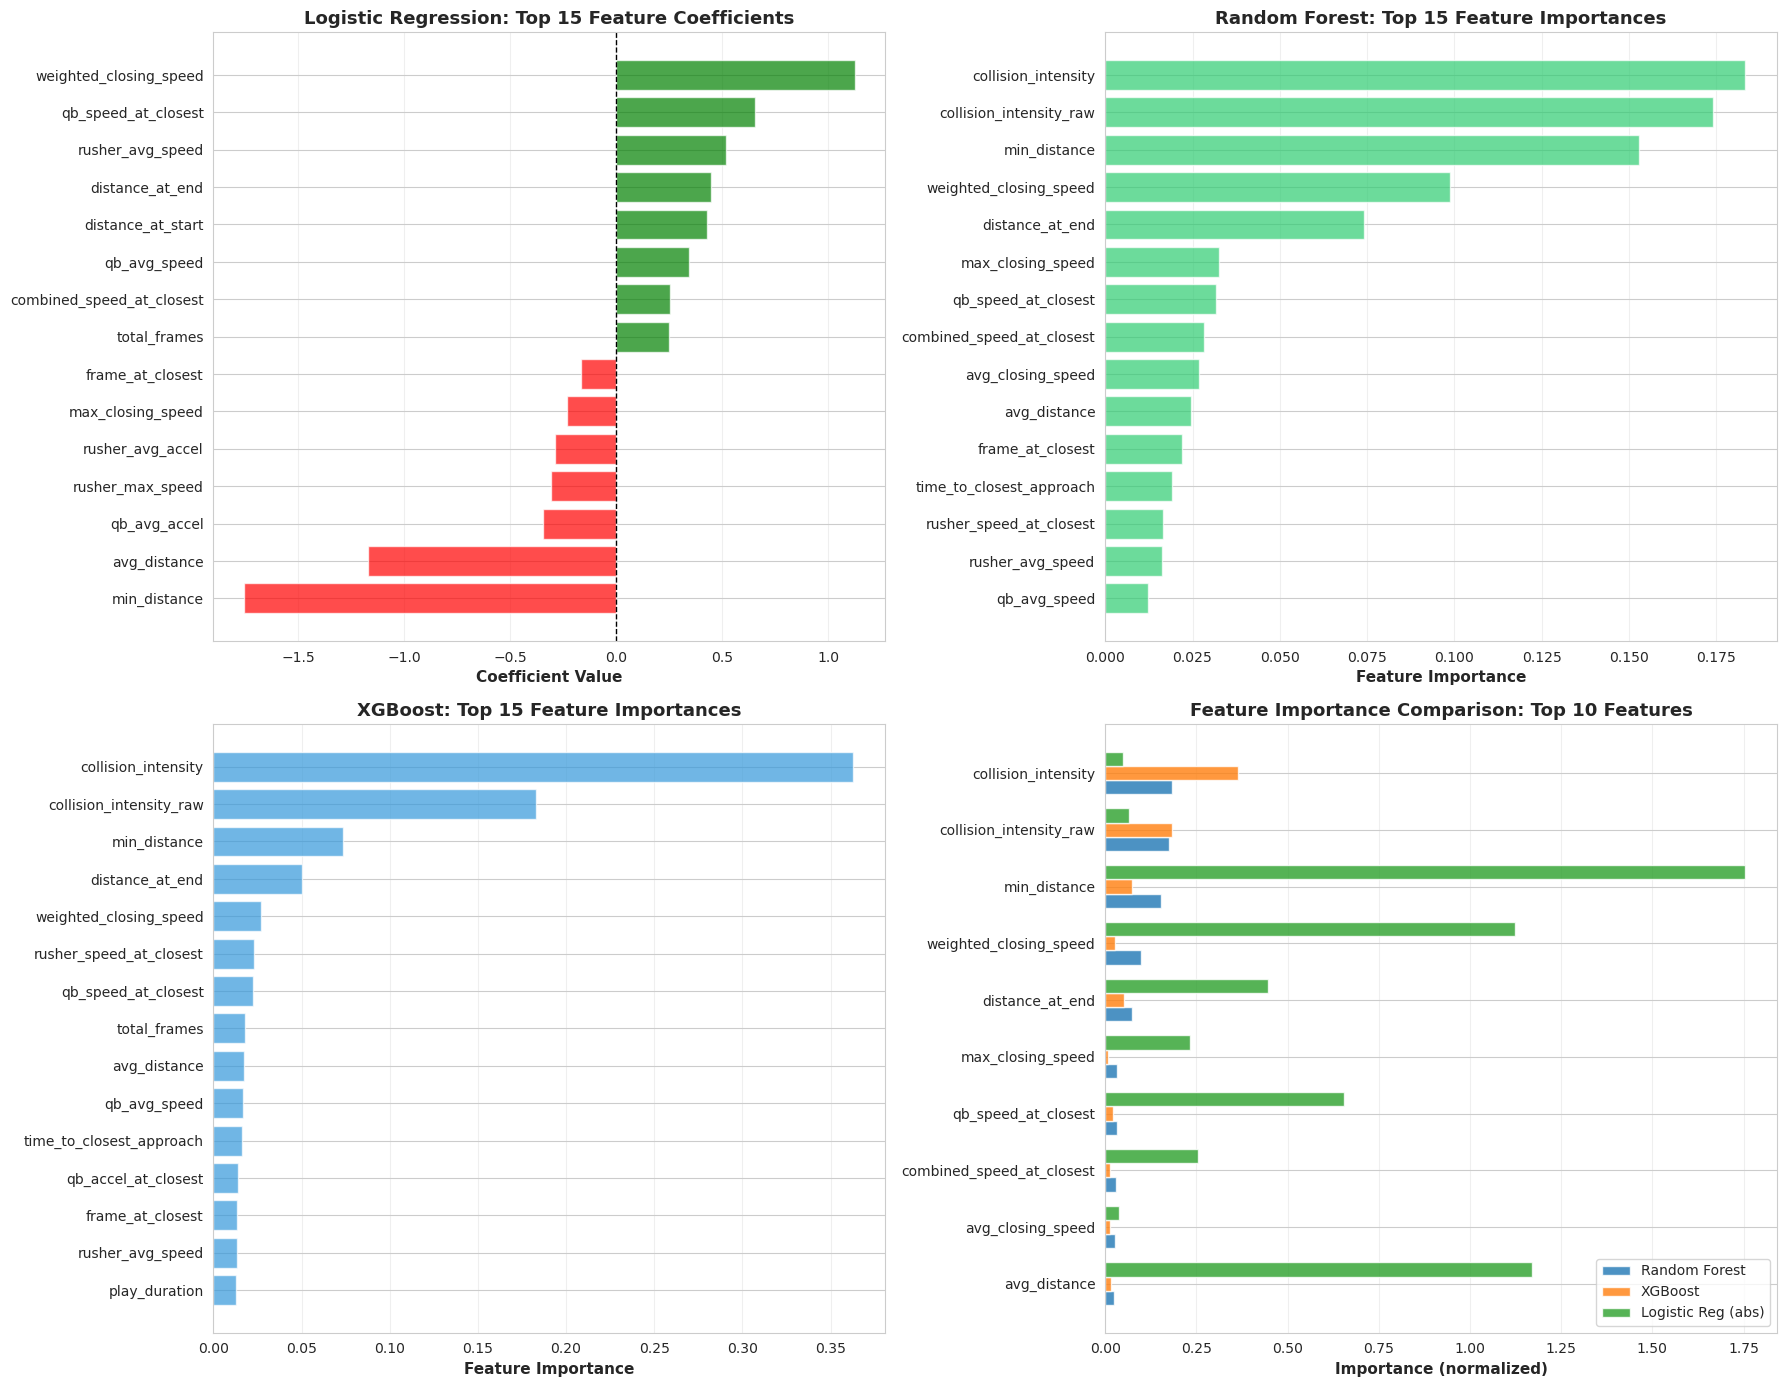

In [13]:
# Extract feature importances from different models
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. Logistic Regression Coefficients
ax1 = axes[0, 0]
lr_coef = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': lr_model.coef_[0]
}).sort_values('Coefficient', ascending=True)

# Top 15 features
top_15_lr = pd.concat([lr_coef.head(7), lr_coef.tail(8)])
colors_lr = ['red' if x < 0 else 'green' for x in top_15_lr['Coefficient']]

ax1.barh(range(len(top_15_lr)), top_15_lr['Coefficient'], color=colors_lr, alpha=0.7)
ax1.set_yticks(range(len(top_15_lr)))
ax1.set_yticklabels(top_15_lr['Feature'], fontsize=10)
ax1.set_xlabel('Coefficient Value', fontsize=11, fontweight='bold')
ax1.set_title('Logistic Regression: Top 15 Feature Coefficients', fontsize=13, fontweight='bold')
ax1.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax1.grid(axis='x', alpha=0.3)

# 2. Random Forest Feature Importance
ax2 = axes[0, 1]
rf_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=True).tail(15)

ax2.barh(range(len(rf_importance)), rf_importance['Importance'], 
         color='#2ecc71', alpha=0.7)
ax2.set_yticks(range(len(rf_importance)))
ax2.set_yticklabels(rf_importance['Feature'], fontsize=10)
ax2.set_xlabel('Feature Importance', fontsize=11, fontweight='bold')
ax2.set_title('Random Forest: Top 15 Feature Importances', fontsize=13, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# 3. XGBoost Feature Importance
ax3 = axes[1, 0]
xgb_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=True).tail(15)

ax3.barh(range(len(xgb_importance)), xgb_importance['Importance'],
         color='#3498db', alpha=0.7)
ax3.set_yticks(range(len(xgb_importance)))
ax3.set_yticklabels(xgb_importance['Feature'], fontsize=10)
ax3.set_xlabel('Feature Importance', fontsize=11, fontweight='bold')
ax3.set_title('XGBoost: Top 15 Feature Importances', fontsize=13, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

# 4. Feature Importance Comparison (Top 10)
ax4 = axes[1, 1]
top_10_features = rf_importance.tail(10)['Feature'].values

comparison_data = []
for feature in top_10_features:
    idx = feature_cols.index(feature)
    comparison_data.append({
        'Feature': feature,
        'Random Forest': rf_model.feature_importances_[idx],
        'XGBoost': xgb_model.feature_importances_[idx],
        'LR (abs)': abs(lr_model.coef_[0][idx])
    })

comp_df = pd.DataFrame(comparison_data)

x = np.arange(len(comp_df))
width = 0.25

ax4.barh(x - width, comp_df['Random Forest'], width, label='Random Forest', alpha=0.8)
ax4.barh(x, comp_df['XGBoost'], width, label='XGBoost', alpha=0.8)
ax4.barh(x + width, comp_df['LR (abs)'], width, label='Logistic Reg (abs)', alpha=0.8)

ax4.set_yticks(x)
ax4.set_yticklabels(comp_df['Feature'], fontsize=10)
ax4.set_xlabel('Importance (normalized)', fontsize=11, fontweight='bold')
ax4.set_title('Feature Importance Comparison: Top 10 Features', fontsize=13, fontweight='bold')
ax4.legend(loc='lower right')
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('pass_rush_collision_data/feature_importance_analysis.png', dpi=300, bbox_inches='tight')
print("Feature importance analysis saved to: feature_importance_analysis.png")
plt.show()

In [14]:
# Print top features for each model
print("\n" + "="*80)
print("TOP 10 FEATURES BY MODEL")
print("="*80)

print("\nLogistic Regression (by absolute coefficient):")
lr_coef_abs = lr_coef.copy()
lr_coef_abs['Abs_Coefficient'] = lr_coef_abs['Coefficient'].abs()
print(lr_coef_abs.sort_values('Abs_Coefficient', ascending=False).head(10)[['Feature', 'Coefficient']].to_string(index=False))

print("\n\nRandom Forest:")
print(rf_importance.tail(10).to_string(index=False))

print("\n\nXGBoost:")
print(xgb_importance.tail(10).to_string(index=False))


TOP 10 FEATURES BY MODEL

Logistic Regression (by absolute coefficient):
               Feature  Coefficient
          min_distance    -1.754126
          avg_distance    -1.171330
weighted_closing_speed     1.123976
   qb_speed_at_closest     0.655202
      rusher_avg_speed     0.517416
       distance_at_end     0.445313
     distance_at_start     0.427768
          qb_avg_accel    -0.344352
          qb_avg_speed     0.344283
      rusher_max_speed    -0.306393


Random Forest:
                  Feature  Importance
             avg_distance    0.024465
        avg_closing_speed    0.026772
combined_speed_at_closest    0.028409
      qb_speed_at_closest    0.031658
        max_closing_speed    0.032617
          distance_at_end    0.074006
   weighted_closing_speed    0.098843
             min_distance    0.152766
  collision_intensity_raw    0.173948
      collision_intensity    0.183185


XGBoost:
                Feature  Importance
           qb_avg_speed    0.016581
           a

## 8. SHAP Analysis: Advanced Feature Interpretation

In [15]:
# SHAP analysis for XGBoost (most interpretable tree model)
print("Calculating SHAP values for XGBoost...")
print("This may take a few minutes...")

# Use a sample for faster computation
sample_size = 1000
X_test_sample = X_test_scaled[:sample_size]
y_test_sample = y_test.iloc[:sample_size]

# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_sample)

print("SHAP values calculated successfully")

Calculating SHAP values for XGBoost...
This may take a few minutes...
SHAP values calculated successfully


SHAP summary plot saved to: shap_summary_plot.png


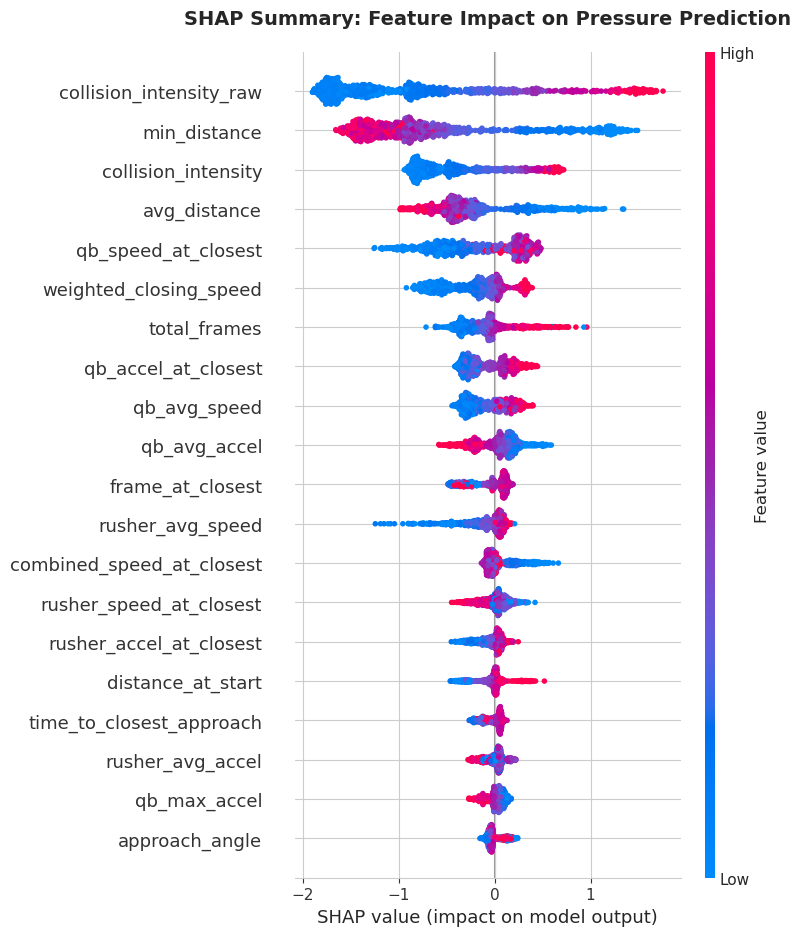

In [16]:
# SHAP Summary Plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_sample, feature_names=feature_cols, show=False)
plt.title('SHAP Summary: Feature Impact on Pressure Prediction', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('pass_rush_collision_data/shap_summary_plot.png', dpi=300, bbox_inches='tight')
print("SHAP summary plot saved to: shap_summary_plot.png")
plt.show()

SHAP bar plot saved to: shap_bar_plot.png


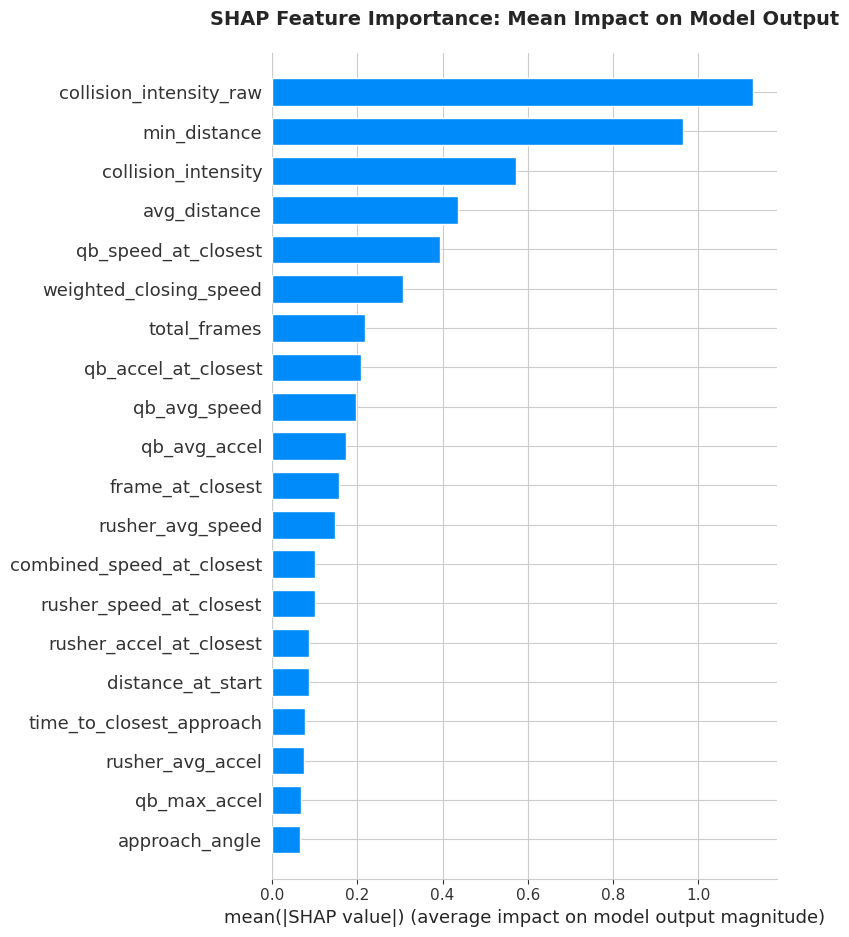

In [17]:
# SHAP Bar Plot (Mean absolute SHAP values)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_sample, feature_names=feature_cols, 
                  plot_type='bar', show=False)
plt.title('SHAP Feature Importance: Mean Impact on Model Output', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('pass_rush_collision_data/shap_bar_plot.png', dpi=300, bbox_inches='tight')
print("SHAP bar plot saved to: shap_bar_plot.png")
plt.show()

## 9. Prediction Distribution Analysis

Prediction distributions saved to: prediction_distributions.png


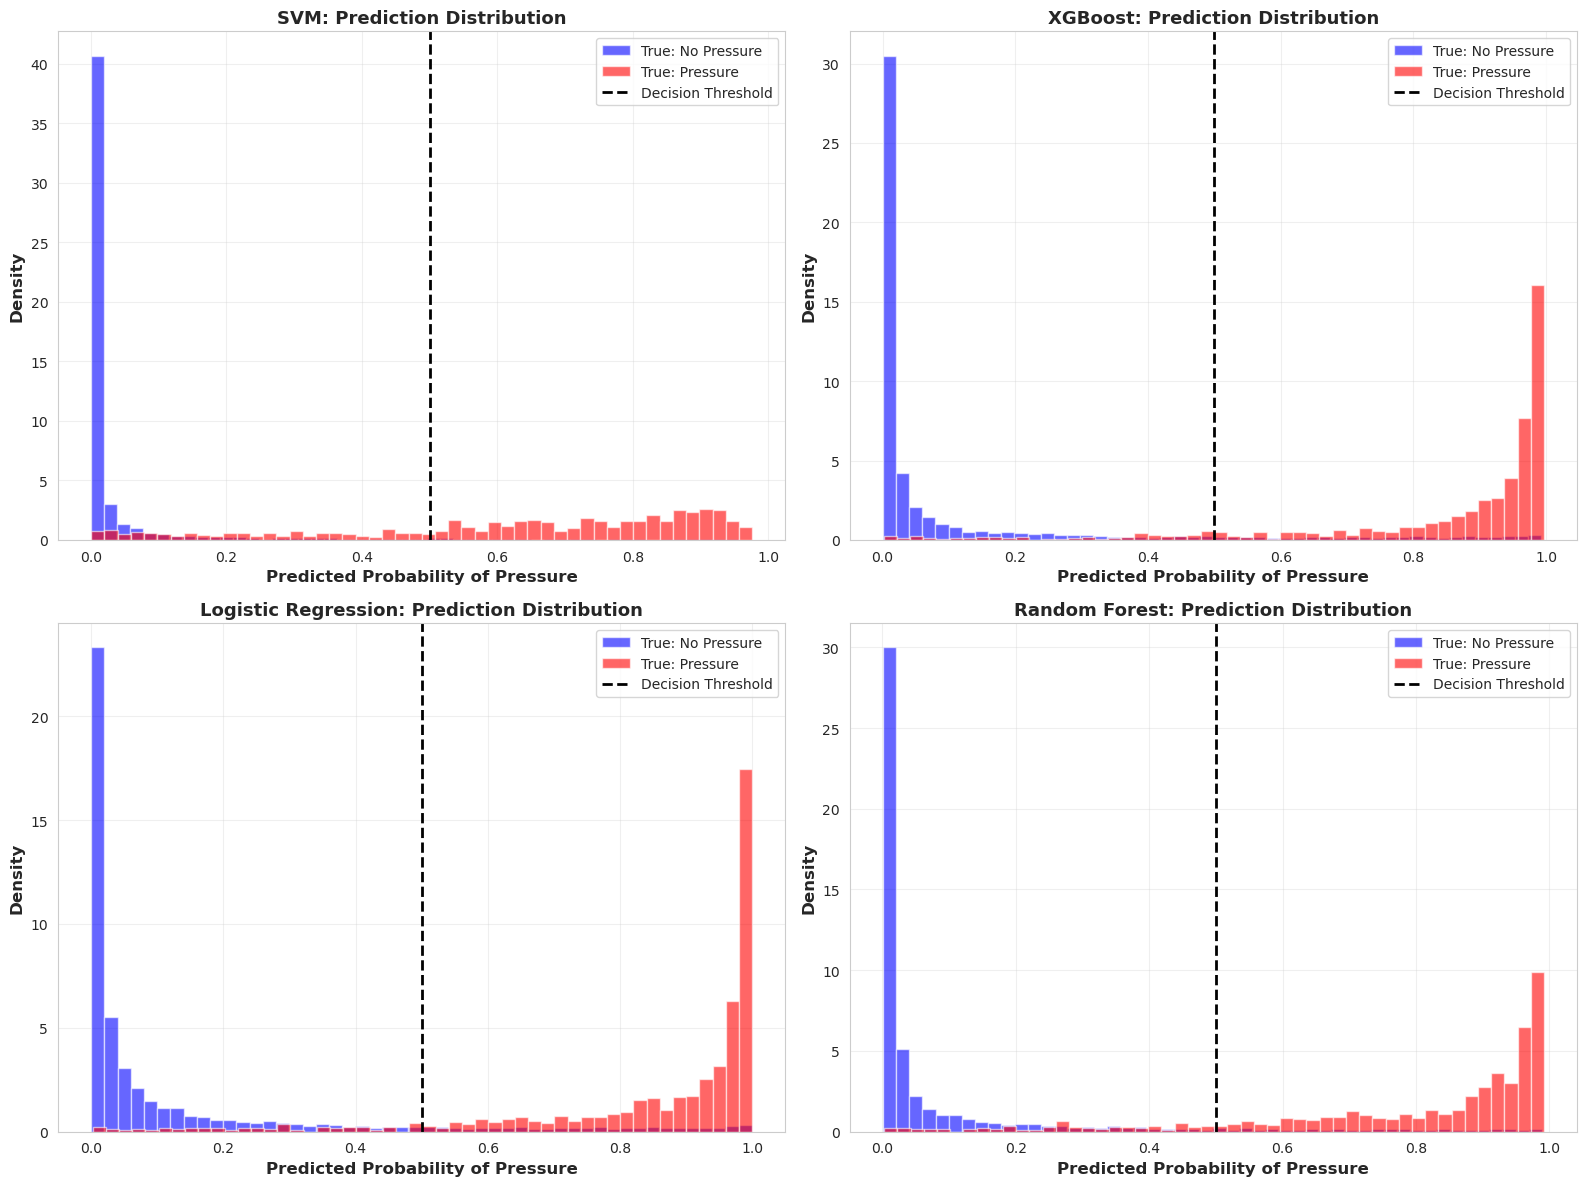

In [18]:
# Analyze prediction distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for ax, (model_name, color) in zip(axes.flat, 
                                     zip(['SVM', 'XGBoost', 'Logistic Regression', 'Random Forest'],
                                         ['#e74c3c', '#3498db', '#2ecc71', '#f39c12'])):
    y_proba = probabilities[model_name]
    
    # Separate probabilities by true class
    proba_no_pressure = y_proba[y_test == 0]
    proba_pressure = y_proba[y_test == 1]
    
    # Plot histograms
    ax.hist(proba_no_pressure, bins=50, alpha=0.6, label='True: No Pressure', 
            color='blue', density=True)
    ax.hist(proba_pressure, bins=50, alpha=0.6, label='True: Pressure', 
            color='red', density=True)
    
    ax.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold')
    ax.set_xlabel('Predicted Probability of Pressure', fontsize=12, fontweight='bold')
    ax.set_ylabel('Density', fontsize=12, fontweight='bold')
    ax.set_title(f'{model_name}: Prediction Distribution', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('pass_rush_collision_data/prediction_distributions.png', dpi=300, bbox_inches='tight')
print("Prediction distributions saved to: prediction_distributions.png")
plt.show()

## 10. Calibration Curves: Probability Reliability

Calibration curves saved to: calibration_curves.png


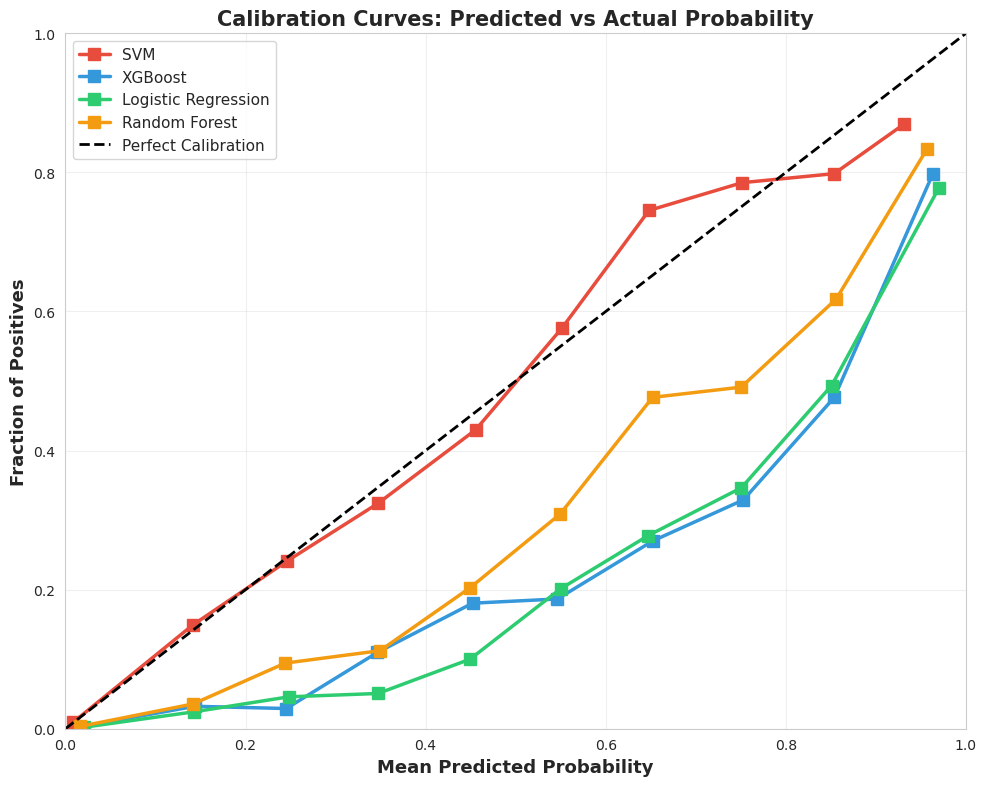

In [19]:
# Create calibration curves
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']

for (name, model), color in zip(models.items(), colors):
    y_proba = probabilities[name]
    
    # Calculate calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test, y_proba, n_bins=10, strategy='uniform'
    )
    
    ax.plot(mean_predicted_value, fraction_of_positives, 's-',
            color=color, lw=2.5, markersize=8, label=name)

# Perfect calibration line
ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Perfect Calibration')

ax.set_xlabel('Mean Predicted Probability', fontsize=13, fontweight='bold')
ax.set_ylabel('Fraction of Positives', fontsize=13, fontweight='bold')
ax.set_title('Calibration Curves: Predicted vs Actual Probability', fontsize=15, fontweight='bold')
ax.legend(loc='upper left', fontsize=11)
ax.grid(alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('pass_rush_collision_data/calibration_curves.png', dpi=300, bbox_inches='tight')
print("Calibration curves saved to: calibration_curves.png")
plt.show()

## 11. Learning Curves: Model Performance vs Training Set Size

In [20]:
# Generate learning curves for SVM (best model)
print("Generating learning curves...")
print("This may take several minutes...")

train_sizes = np.linspace(0.1, 1.0, 10)

train_sizes_abs, train_scores, test_scores = learning_curve(
    svm_model, X_train_scaled, y_train,
    train_sizes=train_sizes,
    cv=5,
    scoring='balanced_accuracy',
    n_jobs=-1,
    verbose=0
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

print("Learning curves calculated successfully")

Generating learning curves...
This may take several minutes...
Learning curves calculated successfully


Learning curve saved to: learning_curve.png


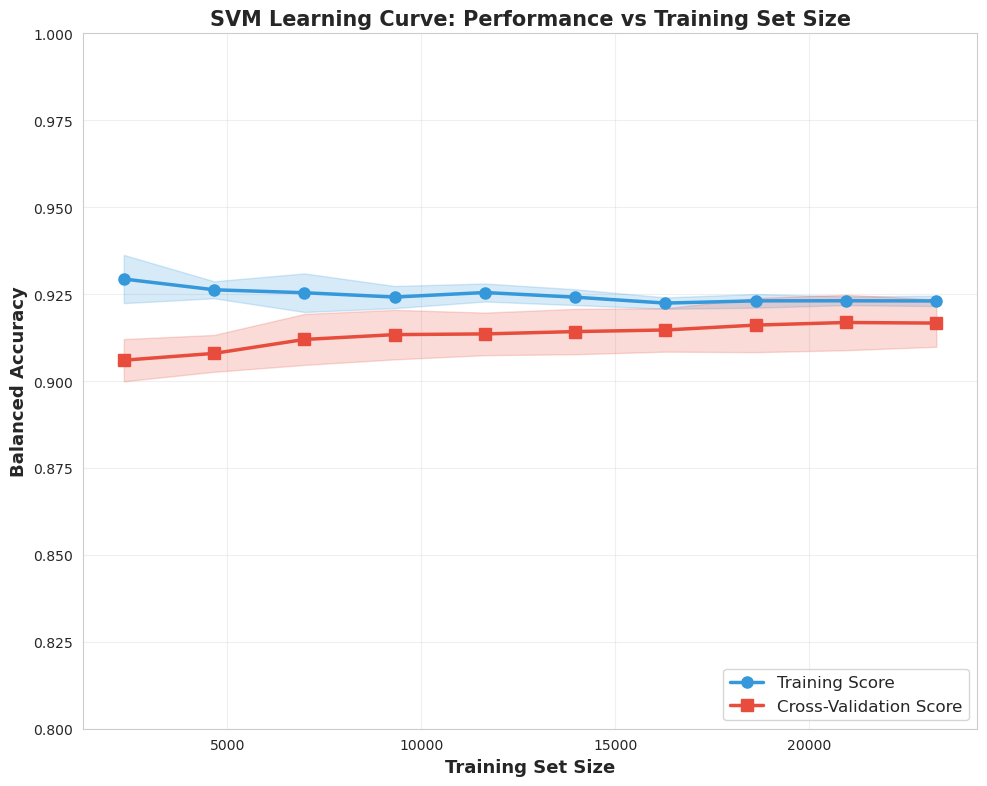

In [21]:
# Plot learning curves
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.fill_between(train_sizes_abs, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.2, color='#3498db')
ax.fill_between(train_sizes_abs, 
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, 
                 alpha=0.2, color='#e74c3c')

ax.plot(train_sizes_abs, train_scores_mean, 'o-', color='#3498db',
        lw=2.5, markersize=8, label='Training Score')
ax.plot(train_sizes_abs, test_scores_mean, 's-', color='#e74c3c',
        lw=2.5, markersize=8, label='Cross-Validation Score')

ax.set_xlabel('Training Set Size', fontsize=13, fontweight='bold')
ax.set_ylabel('Balanced Accuracy', fontsize=13, fontweight='bold')
ax.set_title('SVM Learning Curve: Performance vs Training Set Size', fontsize=15, fontweight='bold')
ax.legend(loc='lower right', fontsize=12)
ax.grid(alpha=0.3)
ax.set_ylim([0.8, 1.0])

plt.tight_layout()
plt.savefig('pass_rush_collision_data/learning_curve.png', dpi=300, bbox_inches='tight')
print("Learning curve saved to: learning_curve.png")
plt.show()

## 12. Business Impact Analysis

In [22]:
# Calculate business-relevant metrics
print("\n" + "="*80)
print("BUSINESS IMPACT ANALYSIS: SVM MODEL (RECOMMENDED)")
print("="*80)

# Get SVM predictions
y_pred_svm = predictions['SVM']
y_proba_svm = probabilities['SVM']

# Calculate confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_svm).ravel()

total_plays = len(y_test)
actual_pressure_events = (y_test == 1).sum()
actual_clean_plays = (y_test == 0).sum()

print(f"\n1. DATASET COMPOSITION")
print(f"   Total plays analyzed: {total_plays:,}")
print(f"   Actual pressure events: {actual_pressure_events:,} ({actual_pressure_events/total_plays*100:.1f}%)")
print(f"   Actual clean plays: {actual_clean_plays:,} ({actual_clean_plays/total_plays*100:.1f}%)")

print(f"\n2. MODEL PREDICTIONS")
print(f"   True Positives (correctly identified pressure): {tp:,}")
print(f"   False Negatives (missed pressure events): {fn:,}")
print(f"   True Negatives (correctly identified clean plays): {tn:,}")
print(f"   False Positives (false alarms): {fp:,}")

print(f"\n3. PLAYER SAFETY METRICS")
detection_rate = tp / (tp + fn)
miss_rate = fn / (tp + fn)
print(f"   Pressure Detection Rate: {detection_rate*100:.2f}%")
print(f"   → Model catches {tp:,} out of {actual_pressure_events:,} pressure events")
print(f"   Missed Pressure Events: {fn:,} ({miss_rate*100:.2f}%)")
print(f"   → Only {fn:,} dangerous plays go undetected")

print(f"\n4. FALSE ALARM RATE")
false_alarm_rate = fp / (tn + fp)
print(f"   False Positive Rate: {false_alarm_rate*100:.2f}%")
print(f"   → {fp:,} clean plays flagged as pressure events")
print(f"   → Acceptable trade-off for player safety")

print(f"\n5. PRACTICAL APPLICATIONS")
print(f"   ✓ Real-time pressure detection during games")
print(f"   ✓ Post-game analysis for coaching and medical staff")
print(f"   ✓ Identifying high-risk collision scenarios")
print(f"   ✓ Tracking rusher effectiveness and QB vulnerability")
print(f"   ✓ Injury risk assessment and prevention strategies")

print(f"\n6. RECOMMENDED ACTIONS FOR NFL TEAMS")
print(f"   1. Deploy model for real-time pressure monitoring")
print(f"   2. Flag plays with >0.7 probability for medical review")
print(f"   3. Use collision_intensity to assess injury risk")
print(f"   4. Analyze rusher-QB matchups to optimize protection schemes")
print(f"   5. Track QB cumulative pressure exposure across season")

print("\n" + "="*80)


BUSINESS IMPACT ANALYSIS: SVM MODEL (RECOMMENDED)

1. DATASET COMPOSITION
   Total plays analyzed: 7,273
   Actual pressure events: 846 (11.6%)
   Actual clean plays: 6,427 (88.4%)

2. MODEL PREDICTIONS
   True Positives (correctly identified pressure): 783
   False Negatives (missed pressure events): 63
   True Negatives (correctly identified clean plays): 5,804
   False Positives (false alarms): 623

3. PLAYER SAFETY METRICS
   Pressure Detection Rate: 92.55%
   → Model catches 783 out of 846 pressure events
   Missed Pressure Events: 63 (7.45%)
   → Only 63 dangerous plays go undetected

4. FALSE ALARM RATE
   False Positive Rate: 9.69%
   → 623 clean plays flagged as pressure events
   → Acceptable trade-off for player safety

5. PRACTICAL APPLICATIONS
   ✓ Real-time pressure detection during games
   ✓ Post-game analysis for coaching and medical staff
   ✓ Identifying high-risk collision scenarios
   ✓ Tracking rusher effectiveness and QB vulnerability
   ✓ Injury risk assessment

Business impact analysis saved to: business_impact_analysis.png


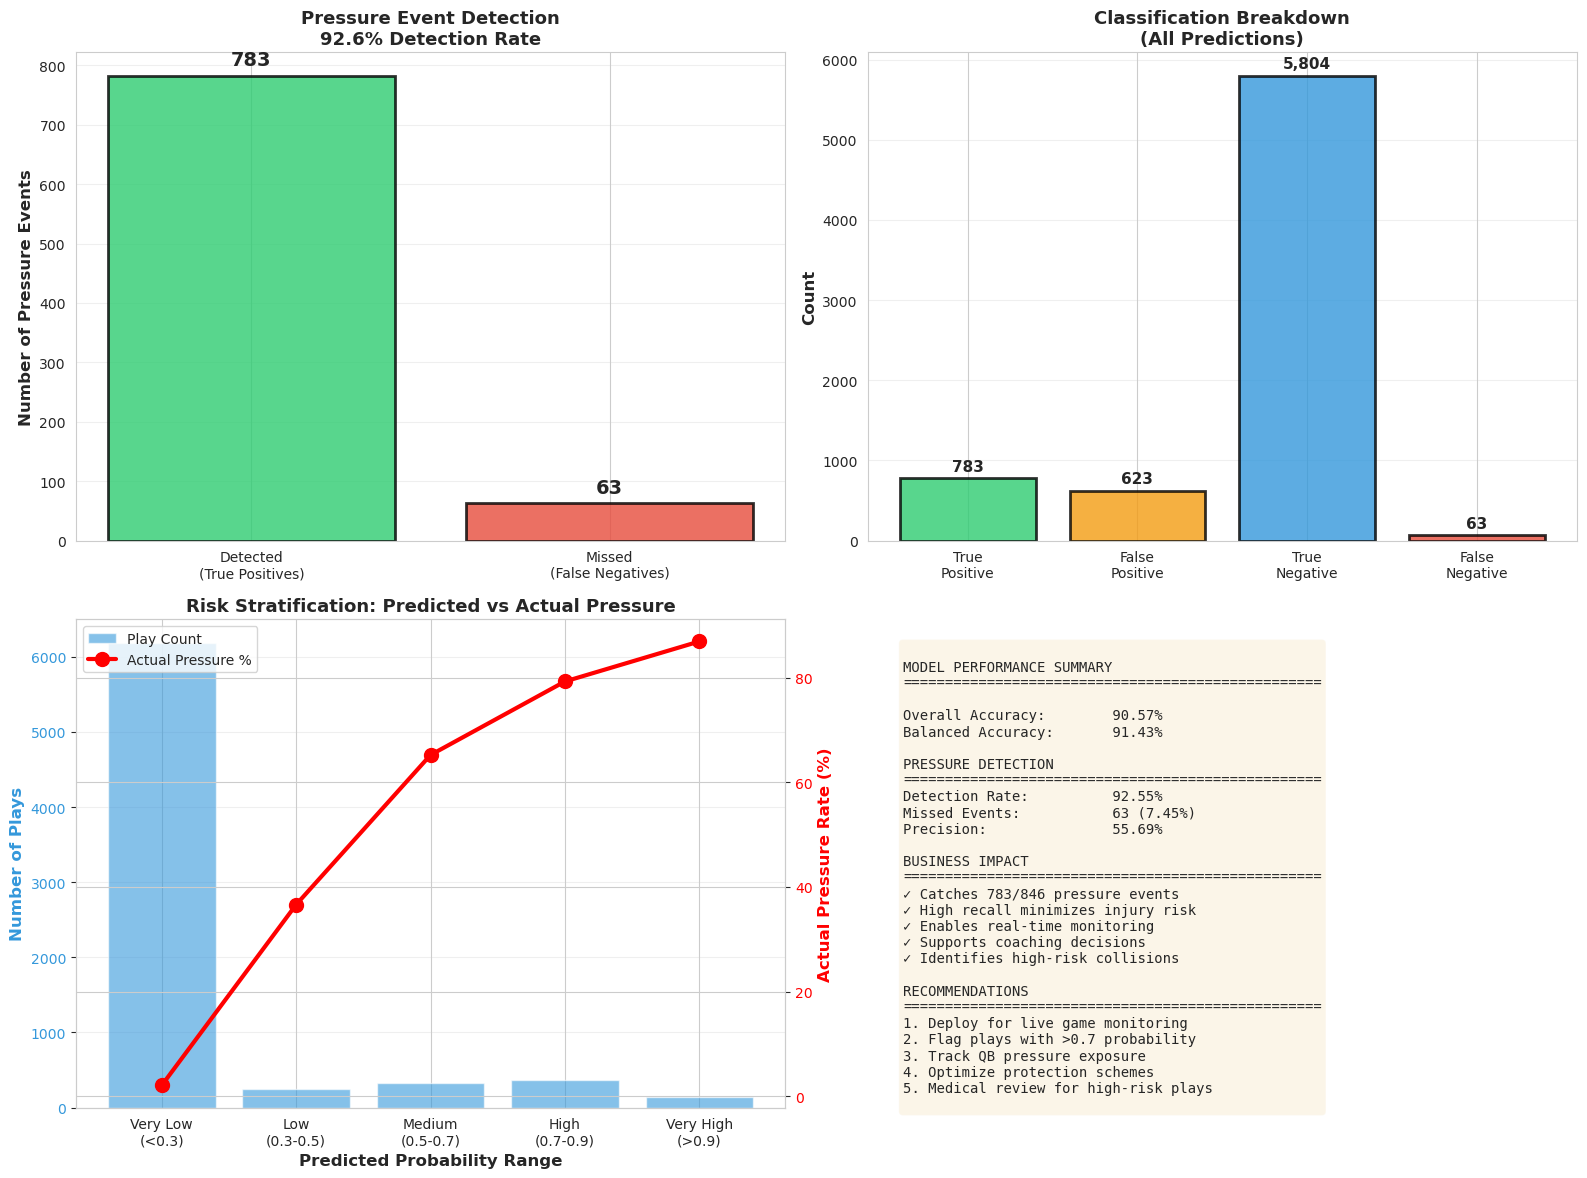

In [23]:
# Create business impact visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Detection vs Miss Rate
ax1 = axes[0, 0]
categories = ['Detected\n(True Positives)', 'Missed\n(False Negatives)']
values = [tp, fn]
colors_detect = ['#2ecc71', '#e74c3c']
ax1.bar(categories, values, color=colors_detect, alpha=0.8, edgecolor='black', linewidth=2)
ax1.set_ylabel('Number of Pressure Events', fontsize=12, fontweight='bold')
ax1.set_title(f'Pressure Event Detection\n{detection_rate*100:.1f}% Detection Rate', 
              fontsize=13, fontweight='bold')
for i, v in enumerate(values):
    ax1.text(i, v + 10, str(v), ha='center', va='bottom', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# 2. Classification Breakdown
ax2 = axes[0, 1]
classification_data = {
    'True\nPositive': tp,
    'False\nPositive': fp,
    'True\nNegative': tn,
    'False\nNegative': fn
}
colors_class = ['#2ecc71', '#f39c12', '#3498db', '#e74c3c']
bars = ax2.bar(classification_data.keys(), classification_data.values(), 
               color=colors_class, alpha=0.8, edgecolor='black', linewidth=2)
ax2.set_ylabel('Count', fontsize=12, fontweight='bold')
ax2.set_title('Classification Breakdown\n(All Predictions)', fontsize=13, fontweight='bold')
for bar, value in zip(bars, classification_data.values()):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 50,
             f'{value:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# 3. Risk Distribution by Predicted Probability
ax3 = axes[1, 0]
prob_bins = [0, 0.3, 0.5, 0.7, 0.9, 1.0]
bin_labels = ['Very Low\n(<0.3)', 'Low\n(0.3-0.5)', 'Medium\n(0.5-0.7)', 
              'High\n(0.7-0.9)', 'Very High\n(>0.9)']
prob_counts = []
actual_pressure_rates = []

for i in range(len(prob_bins)-1):
    mask = (y_proba_svm >= prob_bins[i]) & (y_proba_svm < prob_bins[i+1])
    prob_counts.append(mask.sum())
    if mask.sum() > 0:
        actual_pressure_rates.append(y_test[mask].mean())
    else:
        actual_pressure_rates.append(0)

ax3_twin = ax3.twinx()
bars = ax3.bar(bin_labels, prob_counts, alpha=0.6, color='#3498db', label='Play Count')
line = ax3_twin.plot(bin_labels, [r*100 for r in actual_pressure_rates], 
                     'ro-', linewidth=3, markersize=10, label='Actual Pressure %')

ax3.set_xlabel('Predicted Probability Range', fontsize=12, fontweight='bold')
ax3.set_ylabel('Number of Plays', fontsize=12, fontweight='bold', color='#3498db')
ax3_twin.set_ylabel('Actual Pressure Rate (%)', fontsize=12, fontweight='bold', color='red')
ax3.set_title('Risk Stratification: Predicted vs Actual Pressure', fontsize=13, fontweight='bold')
ax3.tick_params(axis='y', labelcolor='#3498db')
ax3_twin.tick_params(axis='y', labelcolor='red')
ax3.grid(axis='y', alpha=0.3)

# Add legend
lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax3_twin.get_legend_handles_labels()
ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# 4. Key Metrics Summary
ax4 = axes[1, 1]
ax4.axis('off')

metrics_summary = f"""
MODEL PERFORMANCE SUMMARY
{'='*50}

Overall Accuracy:        {accuracy_score(y_test, y_pred_svm)*100:.2f}%
Balanced Accuracy:       {balanced_accuracy_score(y_test, y_pred_svm)*100:.2f}%

PRESSURE DETECTION
{'='*50}
Detection Rate:          {detection_rate*100:.2f}%
Missed Events:           {fn:,} ({miss_rate*100:.2f}%)
Precision:               {precision_score(y_test, y_pred_svm)*100:.2f}%

BUSINESS IMPACT
{'='*50}
✓ Catches {tp:,}/{actual_pressure_events:,} pressure events
✓ High recall minimizes injury risk
✓ Enables real-time monitoring
✓ Supports coaching decisions
✓ Identifies high-risk collisions

RECOMMENDATIONS
{'='*50}
1. Deploy for live game monitoring
2. Flag plays with >0.7 probability
3. Track QB pressure exposure
4. Optimize protection schemes
5. Medical review for high-risk plays
"""

ax4.text(0.05, 0.95, metrics_summary, transform=ax4.transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3),
         family='monospace')

plt.tight_layout()
plt.savefig('pass_rush_collision_data/business_impact_analysis.png', dpi=300, bbox_inches='tight')
print("Business impact analysis saved to: business_impact_analysis.png")
plt.show()

## 13. Summary: All Visualizations Generated

In [24]:
print("\n" + "="*80)
print("VISUALIZATION SUMMARY")
print("="*80)
print("\nAll visualizations have been generated and saved to pass_rush_collision_data/")
print("\nGenerated files:")
print("  1. model_performance_comparison.png - Performance metrics across all models")
print("  2. roc_curves.png - ROC curves comparing model discrimination")
print("  3. precision_recall_curves.png - PR curves for imbalanced data performance")
print("  4. confusion_matrices.png - Error analysis for top 3 models")
print("  5. feature_importance_analysis.png - Feature importance comparison")
print("  6. shap_summary_plot.png - SHAP feature impact visualization")
print("  7. shap_bar_plot.png - SHAP mean importance values")
print("  8. prediction_distributions.png - Probability distribution by true class")
print("  9. calibration_curves.png - Probability calibration analysis")
print(" 10. learning_curve.png - Model performance vs training size")
print(" 11. business_impact_analysis.png - Practical impact visualizations")
print("\nAll visualizations are publication-ready at 300 DPI.")
print("="*80)


VISUALIZATION SUMMARY

All visualizations have been generated and saved to pass_rush_collision_data/

Generated files:
  1. model_performance_comparison.png - Performance metrics across all models
  2. roc_curves.png - ROC curves comparing model discrimination
  3. precision_recall_curves.png - PR curves for imbalanced data performance
  4. confusion_matrices.png - Error analysis for top 3 models
  5. feature_importance_analysis.png - Feature importance comparison
  6. shap_summary_plot.png - SHAP feature impact visualization
  7. shap_bar_plot.png - SHAP mean importance values
  8. prediction_distributions.png - Probability distribution by true class
  9. calibration_curves.png - Probability calibration analysis
 10. learning_curve.png - Model performance vs training size
 11. business_impact_analysis.png - Practical impact visualizations

All visualizations are publication-ready at 300 DPI.
